In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

This post contains my notes on A/B testing and how to make it more powerful. They have been sitting around on my computer for a while now, and it has take a number of long train rides to finish them off. As a result they might seem a bit fragmented, but hopefully they make sense. Please let me know if you find any corrections or have any questions

# Introduction

With the rise of the Internet, we are able to collect more data then ever, faster then ever, in a more controlled environment then ever before. Specifically, it allow us to show two different versions of a product to different customers simultaneously. This allow us to directly measure the impact of what these changes are, and has changed way products are designed. This idea of showing two versions of a product at the same time is known as A/B testing. This paper is a good overview of how websites use it: [Practical Guide to Controlled Experiments on the Web](https://ai.stanford.edu/~ronnyk/2007GuideControlledExperiments.pdf).

The faster you can measure any impact of a change, the more useful these techniques are. In traditional A/B testing, this is usually achieved by increasing the number of people in the experiment, however there are a few variance reduction techniques that offer the ability to use additional information to increase the power of these experiments.

In this post I'm going to look at one of these techniques: [control variates](https://en.wikipedia.org/wiki/Control_variates), and suggest how we can improve it using machine learning. 

# Classic A/B Testing

The goal of controlled experiments is often to estimate the Average Treatment Effect (ATE) of an intervention on some property, $y$, of a population. This is defined as

$\Delta = \hbox{E}[y|I] - \hbox{E}[y|\bar{I}]$

Where $I$ is an indicator for whether or not an individual received the intervention, and the expectation is averaged over the population.

$\Delta$ is the thing we fundamentally what to know - the effect of our treatment. However, because a single individual cannot both receive and not receive the intervention a the same time, we estimate this value by splitting a population into two groups at random, labeled $A$ and $B$, and applying our intervention only to group $B$.

Our estimate of the ATE is then:

$\hat{\Delta} = \bar{y}_{B} - \bar{y}_{A}$

Where $\bar{y}_{i}$ is the sample mean for group $i$. Splitting the samples into groups randomly ensures that no [confounding variables](https://en.wikipedia.org/wiki/Confounding) influence our measurement.

Because we only have a finite number of samples, there will be some error in this estimate. One way to quantify this error is the [confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval) around $\hat{\Delta}$. The interpretation of confidence intervals is 

$P(\hbox{True value} \in \hbox{confidence interval}) = 1 - \alpha$.

Where $1 - \alpha$ is the coverage of the confidence interval, a value we choose to be between 0 and 1. Common values are 90% or 95%. The exact value you want will depend on how you are using your estimate. Note that here the true value is fixed, and it is the confidence interval which is a function of our data, and therefore a random variable.

To estimate the confidence intervals for our estimator, we use the [central limits theorem](https://en.wikipedia.org/wiki/Central_limit_theorem): $\bar{y}_{i}$ is distributed normally with variance $\hbox{Var}(y_{i})/N_{i}$ in the limit of large $N_{i}$. 

Under this approximation the standard deviation of $\hat{\Delta}$ is 

$\sqrt{\hbox{Var}(\bar{y}_{B}) + \hbox{Var}(\bar{y}_{A})}$

Which we can estimate from our data using

$s_{\Delta} = z \sqrt{s_{B}^{2}/N_{B} + s_{A}^{2}/N_{A}}$

Where $s_{i}$ is the sample standard deviation of group $i$. And the confidence intervals are just

$se_{\Delta} = z(\alpha) \sqrt{\hbox{Var}(\bar{y}_{B}) + \hbox{Var}(\bar{y}_{A})}$

Where $z(\alpha) = \Phi^{-1}(1 - \frac{\alpha}{2})$ with $\Phi^{-1}$ as the inverse normal CDF. 

We now have an estimate of the effect size, and our uncertainty of it. Often however, we need to make a decision with this information. How exactly we make this choice should depend on the cost/benefits of the decision, but it is sometimes enough just to ask whether or not our estimated value of $\Delta$ is "significantly" different from zero. This is usually done by using the language of [hypothesis testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing). 

I don't want to go too much into the details of hypothesis testing, because I feel that confidence intervals are often a better way to present information, but since the language of A/B tests are often phrased as hypothesis tests, I should mention a few points:
 - Hypothesis testing for a difference in means between two populations answers the specific question "If we assume that the means of the two distributions are the same, is the probability I obtained my data smaller than $1 - \alpha$?". If the answer is yes, we say the results are "statistically significant".
 - Here $\alpha$ is the same $\alpha$ we used for confidence intervals above. It is a parameter we as experimenters choose (and we choose it before the experiment starts). The larger $1 - \alpha$ is, the more confident we are.
 - If we ran a lot of A/A tests (tests where there is no intervention), we would expect $\alpha$ of them to be "significant" ($\alpha$ is sometimes called the false positive rate, or type one error).
 - Once we have decided on a significance level, another question we can ask is: "if there was a real difference between the populations of $\Delta$, how often would we measure an effect?". This value is called the [statistical power](https://en.wikipedia.org/wiki/Statistical_power), and is often denoted as $1 - \beta$. 
 
If we are to run tests, it is in our best interest to make them as powerful as possible. The power of a test is a function of the sample size, the population variance, our significance level and the effect size. Because of this, it is intimately related to the confidence intervals. It turns out that for an effect size equal to the size of the confidence intervals, the power of a [z-test](https://en.wikipedia.org/wiki/Z-test) is 50%. 

For the rest of these notes, I'm going to call an effect size "detectable" for a given experiment setup if it has power of at least 50%:

$\Delta_{detectable} \ge se_{\Delta}$

I have made this term up to simplify these notes. It is not common statistical jargon, and in reality you should always aim for tests more powerful then this. "Detectable effect size" is a function of only the variance of the underlying population we want to measure, and the sample sizes of each group.

Before continuing, I should note:
 - I've made a lot of approximations here. There will be circumstances where they are all violated.
 - One specific assumption is the normality of the estimator $\hat{\Delta}$ - for large sample sizes this is a good approximation, but for small samples there are more powerful tests you can run.
 - Hypothesis tests in one way to approach detecting differences between two groups. There are others.
 - Statistical significance should not be confused with the _actual_ significance of a result.
 - When we make an intervention, we don't just change the expectation of a population, we may change the underlying distribution completely. Under our normal approximation, this means that the variance of our sample mean may change as well. 

## Generate Dataset 

Having waded through some maths, it is good practice to check our results by simulation. In doing so, we can confirm that even using our ideal assumptions we have an idea what's going on.

To do this we need a mechanism we really generates data. The function below does this.

In [2]:
def generate_dataset(n_samples=100, uplift=0):
    x = np.random.uniform(low=0, high=1, size=n_samples*2)
    y = (
        + 10 * np.abs(x - 0.25)  
        + 2 * np.sin((x * 5) * 2 * np.pi)
        + np.random.normal(size=n_samples*2)
    )
    
    assignment = [1] * n_samples + [0] * n_samples
    np.random.shuffle(assignment)
    
    samples = pd.DataFrame({
        "x": x,
        "y": y,
        "group": assignment
    })
    
    samples.loc[lambda df: df.group == 1, "y"] += uplift
    
    return samples

In [3]:
ds = generate_dataset(n_samples=1000, uplift=1)
ds.head()

,group,x,y
0,0,0.315757,0.023937
1,1,0.882318,9.208470
2,1,0.091788,1.949081
3,0,0.475266,2.460662
4,1,0.686865,5.168338


It generates variables from a distribution. The metric we care about is $y$, and the group assignment is given by the group column. There is also a covariate $x$, but for now we will ignore it. 

This distribution of the metric is show below

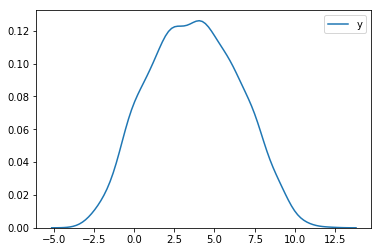

In [4]:
sns.kdeplot(ds.y)

## Running a test

Now we have a method to generate data, we can apply an uplift to one group, and see if we can detect it. Our data generating function applies an uplift by just adding a constant value to all samples in group 1.

For 1000 samples in each group, we expect the confidence intervals in our effect size estimate to be

$z \sqrt{2 \frac{Var(y)}{N}}$

Where $z$ is a constant we set depending on the width of our confidence intervals. For 95% confidence intervals this is about 1.96.

The numeric value is

In [5]:
from scipy.stats import norm

sample_size = 1000
alpha = 0.05
z = norm.isf(alpha / 2)
estimated_variance = ds.y.var()

detectable_effect_size = z * np.sqrt(2 * estimated_variance / sample_size)
detectable_effect_size

0.24117500465055461

So, for an uplift of 0.24, we would expect about 50% of our experiment to have a significant uplift.

Let's take a look

Points with significant effect: 10/20
Points whose confidence interval covers the true effect size: 0/20


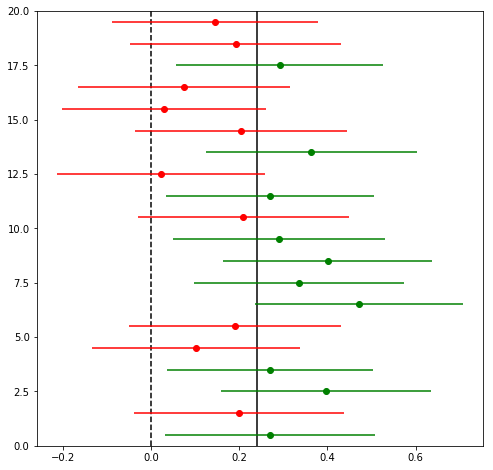

In [6]:
from scipy.stats import ttest_ind

n_experiments = 20
uplift = 0.24
sample_size = 1000
alpha = 0.05
z = norm.isf(alpha / 2)

results = []
is_significant = []

# run some experiments
for _ in range(n_experiments):
    ds = generate_dataset(n_samples=sample_size,uplift=uplift)
    base = ds[ds.group == 0]
    variant = ds[ds.group == 1]
    
    # estimated effect size is just the difference in means
    estimated_effect_size = variant.y.mean() - base.y.mean()
    
    # estiamated error is the combined variance of each group
    estimated_effect_err = 2 * np.sqrt(
        variant.y.var()/variant.shape[0] + 
        base.y.var() / base.shape[0]
    )
    results.append((estimated_effect_size, estimated_effect_err))
    
    # t-test to check if significant
    t,p = ttest_ind(base.y.values, variant.y.values)
    is_significant.append(p <= 0.05)
    
    
# plot everything
y = np.arange(n_experiments) + 0.5
x = np.asarray([i[0] for i in results])
xerr = np.asarray([i[1] for i in results])
is_significant = np.array(is_significant)

plt.figure(figsize=(8,8))
plt.vlines(0, 0, len(results), linestyles="dashed")
plt.vlines(uplift, 0, len(results))
plt.ylim(0,len(results))

mask = is_significant
plt.errorbar(x[mask],y[mask],xerr=xerr[mask], ls="none", c="g", marker="o")
mask = ~mask
plt.errorbar(x[mask],y[mask],xerr=xerr[mask], ls="none", c="r", marker="o");

print("Points with significant effect: {}/{}".format(np.sum(mask), n_experiments))
print("Points whose confidence interval covers the true effect size: {}/{}".format(
    np.sum(np.abs(x-uplift) > xerr), n_experiments))

This image shows the results of 20 simulated experiments for datasets of 1000 samples in each group, and an uplift of 0.24. The points show the estimates of $\Delta$ and the lines show the confidence intervals around the points. Points in green pass a significance test (so we can "reject the null hypothesis", and say that there is a real difference), points in red do not. The solid line is the true effect size, the dashed line is zero.

As expect by our design, about half the points are measured to have a detectable effect (because the power is about 50%), and only one point has confidence intervals which do not cover the true effect size (because our significance level is 95%).

# Improving the Power of our experiment

Now that we understand the system we are dealing with, we can ask the question: how can we increase the detectable effect size of our experiments? We are left with a few options:
 - Increase the effect size
 - Increase the sample size
 - Decrease the variance
 
Increasing the effect size may or may not be possible depending on the effect we are investigating. 

Increasing the sample size is often the easiest way to improve the power of a test, however because the detectable effect size scales as $1/\sqrt{N}$, it becomes harder and harder to increase the power of an experiment this way. In reality the sample size is often constrained by cost or time.

This leaves the option of reducing the variance. 

# Variance Reduction

Up until this point, we have assumed that the our samples were drawn IID from some distribution and nothing else was known about them. In reality, this is often not the case: we might have observed our metric of interest for each subject in some period before the experiment started or we might know some characteristic about the subject. Provided this informations is unaffected by the intervention made during our experiment, it provides us with the ability to reduce the variance. 

There are a number of approaches to include this information, but the clearest idea I've seen is the method of [control variates](https://en.wikipedia.org/wiki/Control_variates).

# Control Variates

I came across the idea of using control variates in the paper [Improving the Sensitivity of Online Controlled Experiments by Utilizing Pre-Experiment Data](http://www.exp-platform.com/Documents/2013-02-CUPED-ImprovingSensitivityOfControlledExperiments.pdf), and it states that if we have a variable which is correlated with our metric of interest, we can improve the variance by simply subtracting a weighted value of it.

Mathematically, if we have a variable $x$ that we want to use as a control variate, and our variable of interest $y$, then we can define a new variable $\tilde{y}$ so that

$\tilde{y} = y - \theta x$

Where $\theta$ is a constant.

The expectation of this new variable is

$E[\tilde{y}] = E[y] - \theta E[x]$

If we choose $x$ such that it's expectation is 0 (for example, by subtracting the mean) then the expectation of $\tilde{y}$ is just the expectation of $y$. The variance of $\tilde{y}$ is given by:

$\hbox{Var}(\tilde{y}) = \hbox{Var}(y) + \alpha^{2}\hbox{Var}(x) - 2 \theta \hbox{Cov}(y,x)$

Minimising the variance with respect to $\theta$, we get

$\theta = \frac{\hbox{Cov}(y,x)}{\hbox{Var}(x)}$

Plugging this back into our original expression, we get

$\hbox{Var}(\tilde{y}) = \hbox{Var}(y)\left(1 - \rho^{2}\right)$

Where 

$\rho^{2} = \frac{\hbox{Cov}(y,x)^{2}}{\hbox{Var}(y)\hbox{Var}(x)}$

which is just the correlation between our metric and the control variate. This means that if there's some correlation between the our control variate and our metric, we can reduce the variance.

# Control Variates in A/B tests

This all looks good, but it relies on us knowing the mean of $x$. In A/B tests, we no longer need to know this. If $x$ is not affected by the intervention, then the mean's of $x$ for each group will be identical, and will canceled out. We can define a new estimator:

$\tilde{\Delta} = \frac{1}{N_{B}}\sum_{i} (y_{B,i} - \theta x_{B,i}) -  \frac{1}{N_{A}}\sum_{i} (y_{A,i} - \theta x_{A,i})$

$ = (\hat{y}_{B} - \hat{y}_{A}) - \theta (\bar{x}_{B} - \bar{x}_{A})$

$ = \hat{\Delta}$

Which has the same expectation value as our original estimator, but with variance reduced by a factor of $\left(1 - \rho^{2}\right)$.

Let's see how it performs in simulations.

## Control Variate Simulations

When we created our initial dataset, I didn't talk about the column $x$. Let's see how $y$ varies with $x$

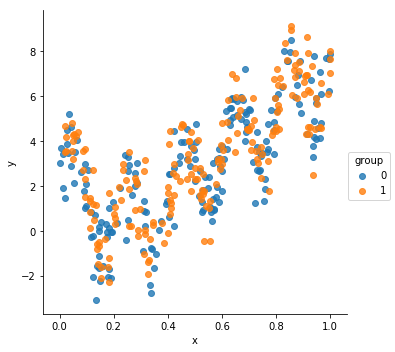

In [7]:
ds = generate_dataset(n_samples=200)
sns.lmplot(data=ds, x="x", y="y", hue="group", fit_reg=False)

There is definitely a lot of structure there - $y$ appears to be some non-linear function of $x$. The exact structure isn't important, what's important to us is that it is correlated with $x$:

In [8]:
correlation = ds.corr().loc["x","y"]
correlation

0.6768194939711959

Before jumping into it, let's define some helper functions. The just compare different estimators by evaluating them on many realizations of the dataset.

In [9]:
def run_many_times(dataset_generator, estimator, n_runs):
    return np.array([estimator(dataset_generator()) for _ in range(n_runs)])

def compare_estimators(dataset_generator, estimators, true_uplift, n_runs=500):
    results = {}
    
    for estimator_name, estimator in estimators.items():
        res = run_many_times(dataset_generator, estimator, n_runs)
        sns.kdeplot(res, shade=True, label=estimator_name)
        
        print("Estimator: {}".format(estimator_name))
        print("\tConfidence Interval Width: {:.3f}".format(2 * np.std(res)))
        print("\tBias: {:.3f}".format(np.mean(res - true_uplift)))
        results[estimator_name] = res
        
    ymin, ymax = plt.ylim()
    plt.vlines(uplift, 0, ymax)
    plt.vlines(0, 0, ymax, linestyles="dashed")
    plt.ylim(0, ymax)
    
    return results

Let's start by looking at our first estimator: the difference in means between each group.

In [10]:
def base_estimator(ds):
    a = ds[ds.group == 0]
    b = ds[ds.group == 1]
    return b.y.mean() - a.y.mean()

And checking how it is distributed

Estimator: base
	Confidence Interval Width: 0.239
	Bias: -0.002


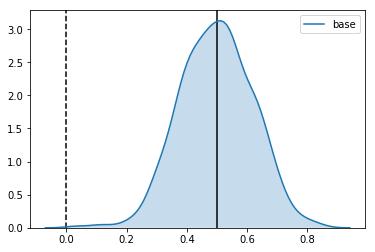

In [11]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
    },
    true_uplift=uplift
)

As expected, it is centered around the uplift, with the expected standard deviation.

Now let's define our control variate estimator and see how it compares:

In [12]:
def cv_estimator(ds):
    theta = ds.cov().loc["x", "y"] / ds.cov().loc["x", "x"]
    
    ds_copy = ds.copy()
    ds_copy.y = ds.y - theta * ds.x
    
    return base_estimator(ds_copy)

Estimator: base
	Confidence Interval Width: 0.230
	Bias: 0.004
Estimator: control variate estimator
	Confidence Interval Width: 0.188
	Bias: 0.003


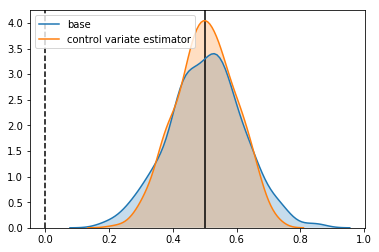

In [13]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator
    },
    true_uplift=uplift
)

We see a reduction in the standard deviation of the estimator. 

Using the calculated correlation, we can check whether it agrees with the reduction we expect:

In [14]:
np.sqrt((1 - correlation ** 2) * estimated_variance) 

2.0255125675111496

Looks good. Without changing anything about our experiment, we have increased it's power. Specifically:
 - We've reduced our detectable effect size by 21%
 - To get the same decrease by collecting more samples, this would take about 60% more samples

# An Alternative View 

Having reassured ourselves that using control variates can increase the power, it's worth thinking again about what we are doing. The form of how we calculate the control variate weighting parameter $\theta$ might seem familiar: this is because it appears in the same form in the coefficient for [ordinary least-square regression](https://en.wikipedia.org/wiki/Ordinary_least_squares).

This provides an interesting interpretation of what we are doing: fitting a model to $y$ given $x$, and then estimating the effect size from the residuals of this fit. Because which of our subjects gets a treatment is randomized and not part of our model, from the point of view of our model it is "noise".

Given the powerful function approximation techniques available in machine learning, it is tempting to ask whether we can improve things further. 

Let's see what happens when we try the same trick, using random forests. To do this, I will use [sklearn's default implementation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor).

In [15]:
from sklearn.ensemble import RandomForestRegressor

def rf_estimator(ds):
    X = ds.x.values.reshape(-1,1)
    y = ds.y.values
    reg = RandomForestRegressor()
    reg.fit(X,y)
    
    ds_copy = ds.copy()
    ds_copy.y = ds.y - reg.predict(X)
    
    return base_estimator(ds_copy)

Estimator: base
	Confidence Interval Width: 0.225
	Bias: 0.001
Estimator: control variate estimator
	Confidence Interval Width: 0.186
	Bias: -0.003
Estimator: random forest estimator
	Confidence Interval Width: 0.043
	Bias: -0.316


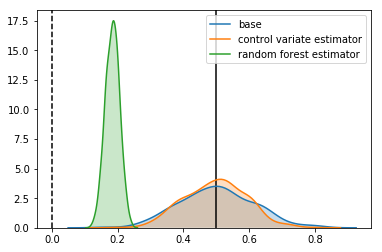

In [16]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator,
        "random forest estimator": rf_estimator
    },
    true_uplift=uplift
)

The confidence intervals are smaller, but the estimate is nowhere near the true effect. What's happened?

# Overfitting and Bias

In machine learning language, we have ["overfitted"](https://en.wikipedia.org/wiki/Overfitting) the data. Our estimator has learned not just the underlying signal in our data, but also the noise. If all we cared about is the prediction accuracy of our estimator, this might not be a bad thing - the is a tradeoff between [variance and bias](http://scott.fortmann-roe.com/docs/BiasVariance.html) when fitting a model to data, and sometimes it is worth trading a bit of bias for a better overall prediction. 

In our situation, things are different. Because we are ultimately using our model to estimate an effect size, any bias will degrade the performance on our final result, leading to a biased estimate.

This is not something specific to the use of random forests. We can see the same behavior in our control variant estimator. The reason we didn't see it before is that in our control variate estimator, we have only one free parameter to fit: the covariance between $x$ and $y$, which is much smaller than the number of datapoints we were using to fit it. If we fit to only a small number of datapoints, we start to see the same thing occurring:

Estimator: base
	Confidence Interval Width: 5.173
	Bias: 0.236
Estimator: control_variate
	Confidence Interval Width: 7.252
	Bias: -3.360


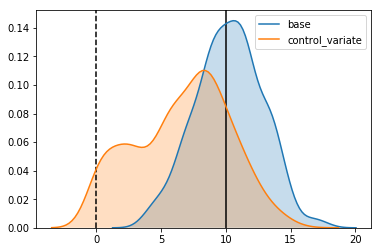

In [17]:
uplift = 10
n_samples = 2
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control_variate": cv_estimator,
    },
    true_uplift=uplift
)

So, if bias is an intrinsic part of this estimators, is there any way we can avoid it and still get that sweet sweet variance reduction without compromising our results?

One approach that I've found is to use the idea of [stacking](http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/).

We start by splitting our data into $K$ disjoint groups. For each of these groups, $i$, we fit an estimator on all the data not in group $i$, and then use this estimator to make a prediction for group $i$. The idea is that even if each of our estimators overfits, because it is not predicting on the data it was trained on, the overfit translates to increased variance.

This might make more sense with an implementation. Let's see how it does

In [18]:
from sklearn.model_selection import KFold

def stacked_estimator(ds):
    kfold = KFold(n_splits=10)

    X = ds.x.values.reshape(-1,1)
    y = ds.y.values
    
    reg = RandomForestRegressor()
    
    ds_copy = ds.copy()
    ds_copy["y_pred"] = 0

    for train_index, test_index in kfold.split(X):
        
        X_train, X_test = X[train_index], X[test_index]      
        y_train, y_test = y[train_index], y[test_index]
        
        reg.fit(X_train,y_train)
        ds_copy.loc[test_index, "y_pred"] = reg.predict(X[test_index])
    
    ds_copy.y = ds_copy.y - ds_copy["y_pred"]
    
    return base_estimator(ds_copy)

Estimator: base
	Confidence Interval Width: 0.237
	Bias: 0.005
Estimator: control variate estimator
	Confidence Interval Width: 0.181
	Bias: -0.002
Estimator: stacked random forest estimator
	Confidence Interval Width: 0.107
	Bias: 0.003


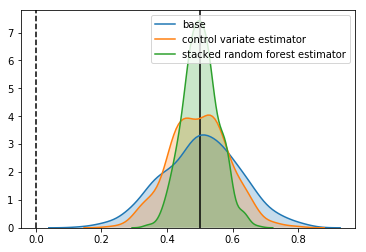

In [19]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator,
        "stacked random forest estimator": stacked_estimator
    },
    true_uplift=uplift
)

It looks good. We've reduced the confidence intervals by another 40% over using linear control variates.

This means compared to our base estimator, we have
 - We've reduced the size of the confidence intervals by 55%
 - To get the same increase by increasing the sample size, we would need 4.8 times as many samples
 
It is worth keeping in mind that when we use models like this, there is some chance that they can be very bad. When the models are bad, we have the risk of _increasing_ the variance of our estimator. For this reason I think that it is useful to add a layer of standard control variate correction on top of the stacked estimator. If our predictions do turn out to be bad, the lack of correlation between the stacked predictions should mean that the linear control variates do not alter the results. This will introduce some small bias, but given a large dataset, this bias should be small.

I implement this below

In [20]:
from sklearn.model_selection import KFold

def stacked_cv_estimator(ds):
    kfold = KFold(n_splits=10)

    X = ds.x.values.reshape(-1,1)
    y = ds.y.values
    
    reg = RandomForestRegressor()
    
    ds_copy = ds.copy()
    ds_copy["y_pred"] = 0

    for train_index, test_index in kfold.split(X):
        
        X_train, X_test = X[train_index], X[test_index]      
        y_train, y_test = y[train_index], y[test_index]
        
        reg.fit(X_train,y_train)
        ds_copy.loc[test_index, "y_pred"] = reg.predict(X[test_index])
    
    ds_copy.x = ds_copy["y_pred"]
    
    return cv_estimator(ds_copy)

Estimator: base
	Confidence Interval Width: 0.240
	Bias: -0.006
Estimator: control variate estimator
	Confidence Interval Width: 0.180
	Bias: -0.002
Estimator: stacked random forest estimator
	Confidence Interval Width: 0.110
	Bias: 0.001
Estimator: stacked random forest CV estimator
	Confidence Interval Width: 0.112
	Bias: 0.001


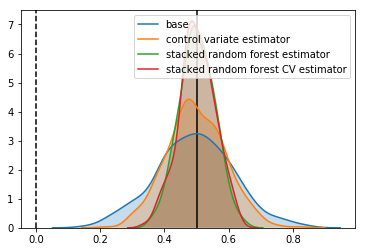

In [21]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator,
        "stacked random forest estimator": stacked_estimator,
        "stacked random forest CV estimator": stacked_cv_estimator,
    },
    true_uplift=uplift
)

In our case, it doesn't change things, but there are situations where it might.

It is also worth pointing out that we are getting close to the fundamental limit of how good an estimator could be. In the function which generates the data, I have included a noise term which add a sample from the unit normal distribution to each datapoint. Because of this, the smallest we can make the size of our confidence intervals is

In [22]:
z * np.sqrt(2 / 1000)

0.087652254057658169

# Related Approaches 

Control Variates is not the only methodology to improve the efficiency of randomized control trials. Another Common approach is know as [covariate adjustment](http://thestatsgeek.com/2014/02/01/adjusting-for-baseline-covariates-in-randomized-controlled-trials/). In it's simplest form, it involves fitting a linear model to the experiment data:

$y = \alpha + \beta x + \beta_{z} z$ 

Where $z$ is an indicator variable, with $z = 0$ when the sample is in the base group and $z=1$ when the sample is in the variant group and $\alpha$, $\beta$ and $\beta_{z}$ are the parameters to be fitted.

The fitted parameter for $\beta_{z}$ is then our estimator for the effect size. There are a number of ways to produce this fit, but most seem to involve minimising the residuals as in OLS. [This paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2562926/) has a good overview of the asymptotic properties of covariate adjustment, and suggest that his approach is almost identical to linear control variate approaches.

# The Bayesian Elephant in the Room

The goal of this post has been to outline some ideas about how we can use prior information about subjects in a random controlled trial to improve our estimate of the effect of the intervention. The standard way to take into account prior information in models is by using [Bayesian techniques](https://xkcd.com/1132/): there is a good overview of the basic ideas in [these posts](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/).

If we stick with linear models, we could frame the problem in a bayesian way, but it feels like this approach is very similar to covariate adjustment. It's not clear if you could extend it to arbitrary models, however if someone has an idea, I'd very interested to hear about it.

# Code

You can find the notebook for this post on github [here](https://github.com/ijmbarr/reducing-variance-ab-tests).